In [1]:
import matplotlib.pyplot as plt
import datetime
import matplotlib as mpl
import numpy as np
from numpy import genfromtxt
import pandas as pd
import datetime
import seaborn as sns
from scipy.stats import pearsonr
import itertools
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import interp1d

from google.colab import drive
drive.mount('/gdrive')
drive_loc = '/gdrive/My Drive/LSTID/'

Mounted at /gdrive


In [2]:
data = pd.read_csv(drive_loc + 'lstid_driver_full_2017_exp.csv')
data['date'] = pd.to_datetime(data['date'])
data['ae_max'].replace('1,070.00', '1070', inplace=True)
data['ae_max'] = data['ae_max'].astype(float)

In [3]:
reference_time = data['date'].iloc[0]
data['date_s'] = (data['date'] - reference_time).dt.total_seconds()
data['dpv'] = np.gradient(data['pv'], (data['date_s']))
data['dsme'] = np.gradient(data['sme'])

In [4]:
da_fil = data[data['tid'] > 0]

In [5]:
def of_name(name):
  if name == 'pv':
    return 'Polar Vortex Index'
  if name == 'ae_max':
    return 'Auroral Electrojet (max)'
  if name == 'ae_slope':
    return 'Auroral Electrojet (Slope)'
  if name == 'dpv':
    return 'Polar Vortex Index Derivative'
  if name == 'u_nh':
    return '60N Zonal Winds'
  if name == 'k_winds':
    return 'Kansas Winds'
  if name == 'sym_h':
    return 'SYM-H'
  if name == 'sme':
    return 'SME'
  if name == 'airs':
    return 'AIRS'
  if name == 'u_slope':
    return '60N Zonal Wind (Slope)'
  if name == 'varea':
    return 'Vortex Area'
  if name == 'dsme':
    return 'DSME'
  if name == 'xrsb_flux':
    return 'GOES 16 XRSB Flux'

In [6]:
def all(df, name):
  if name == 'xrsb_flux':
    da = df[df[name] >= 0.0000005]
    return 'GOES 16 XRSB Flux', da
  if name == 'pv':
    da = df[df[name] >= 100]
    return 'Polar Vortex Index', da
  if name == 'ae_max':
    da = df[df[name] >= 700]
    return 'Auroral Electrojet (max)', da
  if name == 'ae_slope':
    da = df[(df['ae_slope'] >= 250) | (df['ae_slope'] <= -250)]
    return 'Auroral Electrojet (Slope)', da
  if name == 'dpv':
    da = df[(df[name] >= 0.5e-06) | (df[name] <= -0.5e-06)]
    return 'Polar Vortex Index Derivative', da
  if name == 'u_nh':
    da = df[(df[name] >= 50) | (df[name] <= -50)]
    return '60N Zonal Winds', da
  if name == 'k_winds':
    da = df[df[name] > 0]
    return 'Kansas Winds', da
  if name == 'sym_h':
    da = df[df[name] <= -20]
    return 'SYM-H', da
  if name == 'sme':
    da = df[df[name] >= 400]
    return 'SME', da
  if name == 'airs':
    da = df[df[name] >= 0.0035]
    return 'AIRS', da
  if name == 'u_slope':
    da = df[(df[name] >= 5) | (df[name] <= -5)]
    return '60N Zonal Wind (Slope)', da
  if name == 'varea':
    da = df[df[name] >= 10]
    return 'Vortex Area', da
  if name == 'dsme':
    da = df[(df['dsme'] >= 200)]
    return 'DSME', da

In [7]:
def met_check(name):
  if name == 'airs' or name == 'pv' or name == 'dpv' or name == 'k_winds' or name == 'varea' or name == 'u_nh' or name == 'u_slope':
    return True
  else:
    return False

In [8]:
def geo_check(name):
  if name == 'sme' or name == 'dsme' or name == 'ae_max' or name == 'ae_slope' or name == 'sym_h':
    return True
  else:
    return False

In [9]:
# Group by month
per_da_geo = []
per_da_met = []
data_fil = da_fil
data_fil.set_index('date', inplace=True)
column_names = data.columns.tolist()
grouped = data_fil.resample('M')
monthly_dfs = {name.strftime('%b'): group for name, group in grouped}
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month_name in month:
  for driver in column_names:
    if driver == 'date':
      continue
    if driver == 'date_s':
      continue
    if driver == 'tid':
      continue
    if driver == 'Unnamed: 0':
      continue
    if driver == 'xrsb_flux':
      continue
    da = monthly_dfs[month_name]
    num_tid = np.shape(da)
    da = all(da, driver)
    num_rows = np.shape(da[1])
    percent = num_rows[0]/num_tid[0]*100
    if geo_check(driver):
      per_da_geo.append({'month': month_name, 'driver': driver, 'percent': percent})
    if met_check(driver):
      per_da_met.append({'month': month_name, 'driver': driver, 'percent': percent})

per_da_met = pd.DataFrame(per_da_met, columns=['month', 'driver', 'percent'])
per_da_geo = pd.DataFrame(per_da_geo, columns=['month', 'driver', 'percent'])

per_da_met.set_index(['month', 'driver'], inplace=True)
per_da_geo.set_index(['month', 'driver'], inplace=True)

In [12]:
met_res = per_da_met.reset_index()
geo_res = per_da_geo.reset_index()
mon_met = met_res['month'].unique()
mon_met_mapping = {month: i for i, month in enumerate(mon_met)}
met_res['month_num'] = met_res['month'].map(mon_met_mapping)
mon_geo = geo_res['month'].unique()
mon_geo_mapping = {month: i for i, month in enumerate(mon_geo)}
geo_res['month_num'] = geo_res['month'].map(mon_geo_mapping)

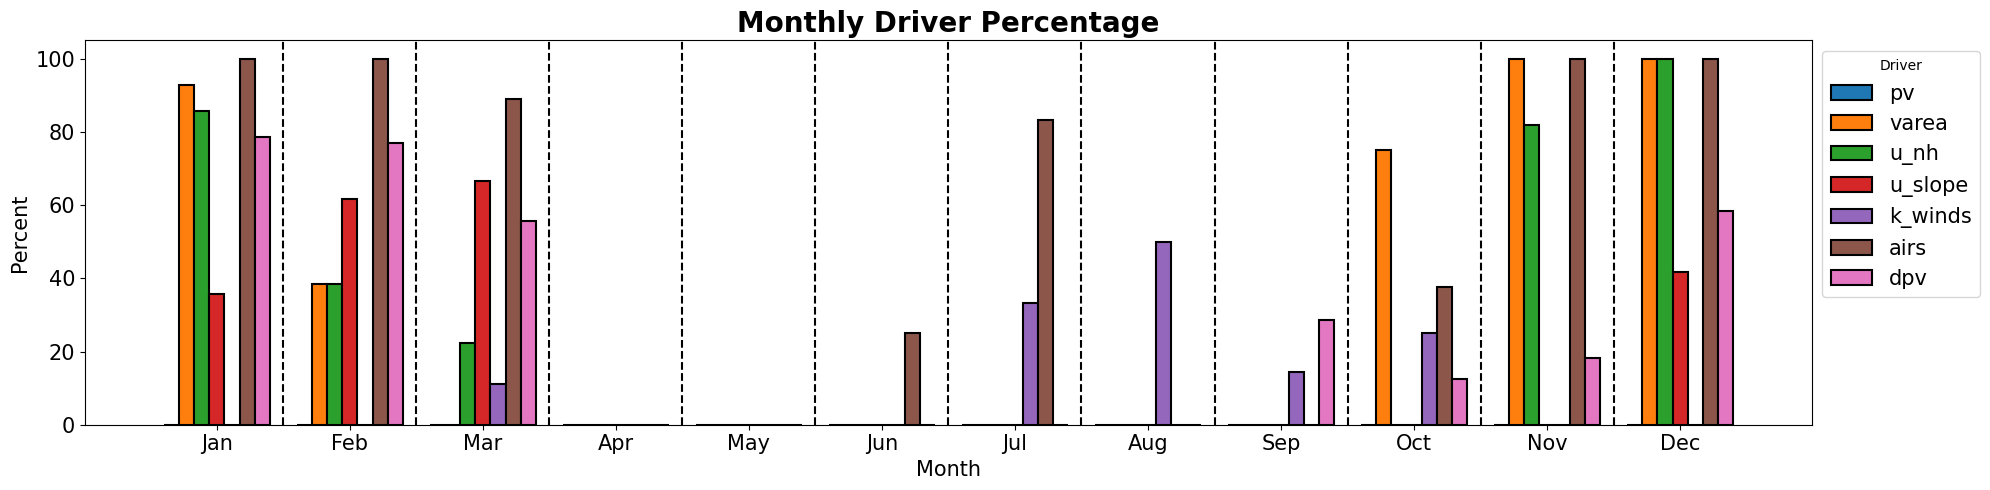

In [26]:
plt.figure(figsize=(20, 5))

# Generate unique offsets for each driver
drivers = met_res['driver'].unique()
n_drivers = len(drivers)
bar_width = 0.8 / n_drivers  # Width of each bar
offsets = np.linspace(-0.4, 0.4, n_drivers, endpoint=False) + bar_width / 2

# Plotting each bar with offsets
for i, driver in enumerate(drivers):
    df_driver = met_res[met_res['driver'] == driver]
    plt.bar(df_driver['month_num'] + offsets[i], df_driver['percent'], width=bar_width, label=driver, edgecolor='black', linewidth=1.5)

# Adding labels and title
plt.xlabel('Month',fontsize = 15)
plt.ylabel('Percent',fontsize = 15)
plt.title('Monthly Driver Percentage',fontsize = 20, fontweight='bold')
plt.xticks(ticks=np.arange(len(mon_met)), labels=mon_met,fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(title='Driver', bbox_to_anchor=(1, 1), loc='upper left',fontsize = 15)

# Adding vertical lines for month boundaries
for i in range(1, len(mon_met)):
    plt.axvline(x=i - 0.5, color='black', linestyle='--', linewidth=1.5)

#for month in mon_met:
#    max_value = met_res[met_res['month'] == month]['percent'].max()
#    month_num = mon_met_mapping[month]
#    plt.axhline(y=max_value, xmin=month_num - 0.4, xmax=month_num + 0.4, color='black', linestyle='--', linewidth=1.5)

# Show plot
plt.tight_layout()
plt.show()

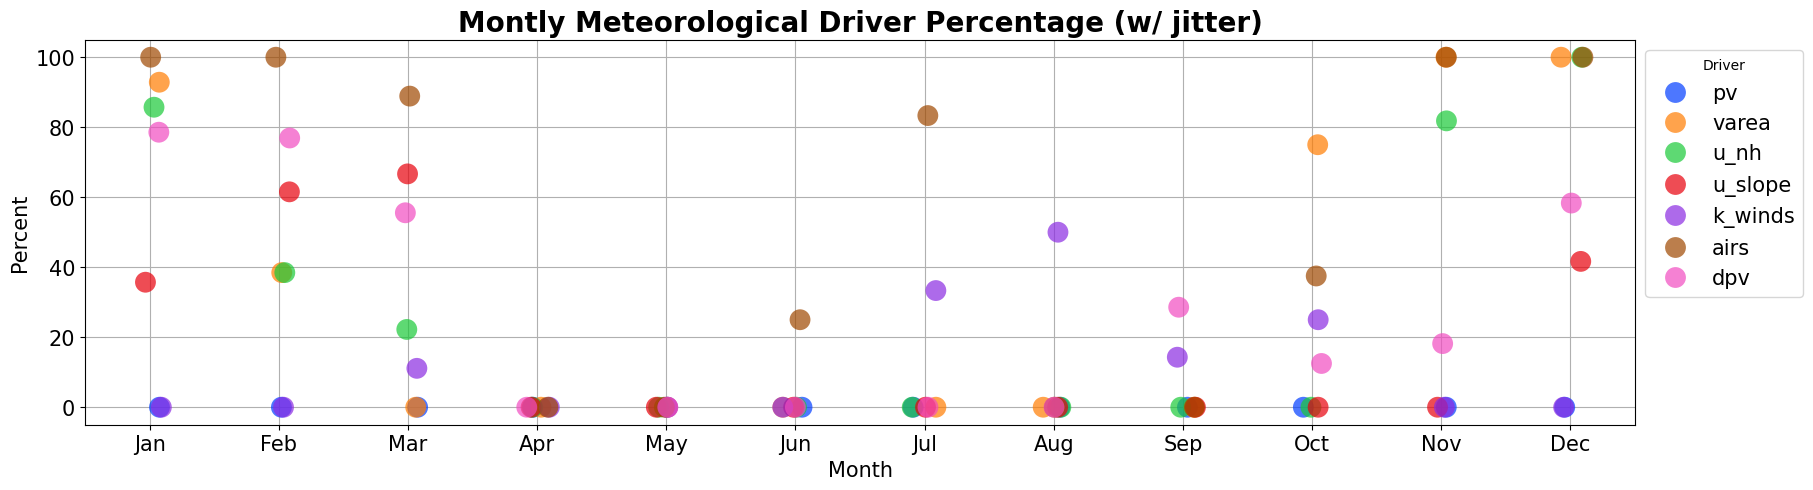

In [10]:
#per_data = per_da_met.reset_index()

# Create a scatter plot
plt.figure(figsize=(20, 5))

# Scatter plot with automatic default colors
sns.stripplot(data=per_da_met, x='month', y='percent', hue='driver', palette='bright',s=15, alpha=0.7, jitter=True)

# Create a legend
plt.legend(title='Driver', bbox_to_anchor=(1, 1), loc='upper left', fontsize = 15)

plt.xlabel('Month',fontsize = 15)
plt.ylabel('Percent',fontsize = 15)
plt.title('Montly Meteorological Driver Percentage (w/ jitter)',fontsize = 20, fontweight = 'bold')
plt.tick_params(labelsize = 15)
plt.grid(True)
plt.show()